# <p><font color=deepskyblue>&#9658; INTRODUCTION TO SCRAPING AND DATA MINING &#9664;</font></p>
# <p><font color=deepskyblue>Collect Tweets's Data into MongoDB and visualise them with NetworkX </font></p>


___
# <p><font color=teal> &#129414; Objectives </font></p>

**We want to be able to extract tweets based on one or several specific hastags from twitter to then analyse them.**

To achieve this goal we will go through these steps:

- **[Set Up](#setup)** (1h)
    - We assume that you already have Jupyter Notebook and are looking at it right now
    - Install **MongoDB**
    - Get your personal credentals from the **Twitter API**
    - Select some **hastags** related to an event or movement (/!\ we will use tweepy stream and you cannot collect tweets older than one week with it, so the event has to be in trends)
- **[Data Mining](#datamining)** (1h)
    - Use the Stream API to **collect tweets** to create our dataset (I collected 5000 tweets in another project, I guess 1000 would be a minimum, so it's better when it's a very trendy topic like a political election or an international sports event for instance)
- **[Data Analysis](#dataanalysis)** (1h)
    - Analyse the information we collected
    - **Visualise** networks with graphs

___
# <p><font color=teal> &#129414; Useful sources </font></p>

* [**Mining the Social Web, 2nd Edition by Matthew A. Russell**](https://www.webpages.uidaho.edu/~stevel/504/Mining-the-Social-Web-2nd-Edition.pdf) (really cool and detailed book for mining Twitter, Facebook, Linkedin, Google+, web pages, etc!)
* [twitter doc](https://developer.twitter.com/en/docs/tweets/filter-realtime/api-reference/post-statuses-filter) the API limits permit you to do the requests inside the boundaries of the API
* composition of a [tweet object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)
* [Stevesie Data youtube channel](https://www.youtube.com/c/StevesieData/videos) (Learn how to scrape data at scale from any public API)


___
# <p><font color=teal> &#129414; Frequent questions </font></p>

* **What is an API ?** <br> An Application Programming Interface (API) is a software intermediary that allows two applications to talk to each other. In other words, an API is the _messenger_ that delivers your request to the provider that you're requesting it from and then delivers the response back to you. It is a tool set that programmers can use in helping them create software.
* **What scrapping / data mining ?** <br> _Scraping_ refers to the process of extracting data from web sources and structuring it into a more convenient format. It does not involve any data processing or analysis. (you _collect_ data) <br>_Data mining_ is defined as a process used to extract usable data from a larger set of any raw data. It require knowledge in computer science, databases and statistics. Data mining refers to the process of analyzing large datasets to uncover trends and valuable insights. It does not involve any data gathering or extraction. You _look_ at the (most of the time HUGE) dataset that you have created by extracting data from somewhere. (you _organise_ data) 
* **What is MongoDB ?**<br> MongoDB is a _NoSQL database_ (it means that the data isn't stored in tables but in documents. It is useful for projects that need to be developed rapidely when you don't have a full overview and it offers flexibility, so it is less strict).<br><br>
* **Is it legal ?** <br> Yes, the application can only access public information on Twitter. You can check out twitter's rules and policies about their API usage [here](https://help.twitter.com/en/rules-and-policies/twitter-api), and you can watch the video [Is Data Scraping Legal in 2020? Recent Court Rulings & Data Scraping Guidelines For Staying Legal](https://youtu.be/btjtuMsfdb4) by Stevesie Data.
* **Is it free ?** <br> Twitter Streaming API is free to use but gives you limited results (and limited licensing usage of the data)
* **Do I need to have a twitter account or give my data to twitter ?** <br> Yes, to have access to the API, you need to activate your "developer account", you will provide information about how you will use the collected data and give your phone number. Otherwise you cannot have access to the stream of tweets. If you don't want to do it, you still can use the json file of collected tweets that I provided in the repository. An other solution is to download .har files from a browser<br><br>
* **What is the limit of tweets that you can collect ?** <br> For the GET method (the one that we use to get the tweets) the limit is set to 100,000 requests per day.
* **How old are the tweets that I can collect ? Can I collect tweets from the FIFA world cup 2010 ?** <br> The Twitter Search API searches against a _sampling_ of recent Tweets published in the _past 7 days_. With the Premium or Entreprise versions of the API, you can have access to tweets from the past 30 days, or have access to archives back to 2006. However there is something called "[Sandbox](https://developer.twitter.com/en/docs/twitter-api/premium/search-api/overview)" (we don't use it here) that gives you access to archive data with a limited amount of requests. Another trick can be using .har files
* **What kind of data do you have access to ?** <br> You have access to public twitter information: names, number of likes, text of tweets, number of followers, language, etc. Here is a [tweet object](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet) that can give you an idea of what you can get.

* **Does it work only for hashtags ?** <br> No, with words as well, but hastags assure a standardized formatting for your request


___
# <p><font color=teal> &#129414; Set Up </font></p> <a id="setup"></a>


* Install [pymongo](https://pymongo.readthedocs.io/en/stable/installation.html) `python -m pip install pymongo` ([installation youtube video for Windows (no command line)](https://youtu.be/FwMwO8pXfq0))
* Install [MongoDB Compass](https://www.mongodb.com/try/download/compass)
* Install [tweepy](http://docs.tweepy.org/en/latest/install.html) `pip install tweepy`
* [Create a twitter application](https://developer.twitter.com/en/application/intent) on [Twitter API](https://apps.twitter.com/) and get your acess tokens / credentials <br>
(TUTORIAL FOR THIS STEP: [Authenticate a Python Application with Twitter using Tweepy](https://www.digitalocean.com/community/tutorials/how-to-authenticate-a-python-application-with-twitter-using-tweepy-on-ubuntu-14-04)). You will need to enter personal data like your phone number and get validation to have access to developer applications
* Install [networkx](https://networkx.org/) and [pyvis](https://pyvis.readthedocs.io/en/latest/install.html) for the visualisation part `pip install networkx` and `pip install pyvis`

<p><font color=white>https://rso6eziprue.typeform.com/to/i11T93mb</font></p>

## <p><font color=lightsteelblue> &#129370; PART 1: Collect the tweets </font></p> <a id="datamining"></a>
### a) Import libraries

In [1]:
# access the twitter API
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
# work with json files
import json
# database mongodb working with python
import pymongo
# mongo connection
from pymongo import MongoClient

### b) Load your personal secret keys

You need to create a `.keys.json` file in the root of your folder with your personal access tokens that you got on the [Twitter API](https://apps.twitter.com/) as explained in Set Up:

`[{
    "consumer_key": "xxxxx",
    "consumer_secret": "xxxxx",
    "access_token": "",
    "access_token_secret": "xxxxx"
}]`

If you don't want to use Twitter API, you won't be able to do the next steps of collecting the tweets. You will be able to use the .json file that I provided and that will be used in **PART2 b**

In [2]:
# Open and load the credentals stored in the file .keys.json
with open('.keys.json', 'r') as myFile:
    data = json.load(myFile)

consumer_key = data[0]['consumer_key']
consumer_secret = data[0]['consumer_secret']
access_token = data[0]['access_token']
access_token_secret = data[0]['access_token_secret']

### c) Fetch the stream of tweets

**Twitter time !** Now you need to choose what you want to collect so go in the top tweets and see what's up !

Here we will use **MongoDB** with tweepy ! What is MongoDB ? <br>
MongoDB is a **NoSQL database** (it means that the data isn't stored in tables but in documents. It is useful for projects that need to be developed rapidely when you don't have a full overview and it offers flexibility, so it is less strict). <br>
The **documents** are saved into **JSON format**.<br>
**Databases** hold one or more collections of documents.<br>
MongoDB stores documents in **collections**. Collections are analogous to tables in relational databases.<br>
(Learn more in [Mongo DB documentation](https://docs.mongodb.com/manual/core/databases-and-collections/))

<img src="MongoDBdbcol.png" align="left" style="width: 500px;"/>

In [3]:
# Tweet collect
client = MongoClient('localhost', 27017)
db = client['analysis'] # your database name // example: client['YOUR_DB_NAME']
collection = db['loisecuriteglobale3'] # your collection name // example: db['YOUR_COLLECTION_NAME']
count_collectedtweets = 0 # made to keep track of how much tweets you have collected

class StdOutListener(StreamListener):
    """ A listener handles tweets that are received from the stream.
    This is a basic listener that just prints received tweets to stdout.
    """

    def on_data(self, data):
        print(type(data))
        collection.insert_one(json.loads(data)) # add the collected tweet into the collection
        global count_collectedtweets 
        count_collectedtweets = count_collectedtweets+1
        print(count_collectedtweets) # print the number of the collected tweet while collecting
        # Fix a limit of tweets to collect (I would say that at least 1000 would be nice)
        if count_collectedtweets < 100:
            return True #collect
        else:
            return False #stop

    def on_error(self, status):
        print(status)

if __name__ == '__main__':
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)
    print('START COLLECTING TWEETS')
    stream.filter(track=['loisecuriteglobale', 'violencepoliciere','racisme'])
    print('--- STOP THE SCRIPT ---')
    #example: stream.filter(track=['GJ', 'giletsjaunes', 'greve','macron','retraites']) #results in french
    #example: stream.filter(track=['covid19', 'covid', 'corona','confinement','masques']) #results in various languages

START COLLECTING TWEETS
<class 'str'>
1
<class 'str'>
2
--- STOP THE SCRIPT ---


<p><font color=white>
# alternative fast way
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_token_secret)
#api = tweepy.API(auth)

#results = api.search(q='cheese', count=100)

#json_data = [r._json for r in results]

#df = pd.io.json.json_normalize(json_data)
</font></p> 

## <p><font color=lightsteelblue> &#128035; PART 2: Create a database </font></p>

### a) Check and import the collection inside a .json file

If you use MongoDB compass, connect locally, then export your .json file and save it in your root folder

Connection string to connect locally: **mongodb://localhost:27017/admin?readPreference=primary&appname=MongoDB%20Compass&ssl=false**


<img src="MongoDBcompassLocalhost.png" style="width: 500px;"/>
<img src="exportcollectioninjson.png" style="width: 500px;"/>
<img src="exportcollectioninjson2.png" style="width: 500px;"/><br>

Otherwise you can use the MongoDB prompt:

`mongoexport --db YOUR_DB_NAME --collection YOUR_COLLECTION_NAME --out YOUR_COLLECTION_NAME.json`

example:`mongoexport --db analysis --collection loisecuriteglobale3 --out loisecuriteglobale3.json`

If you already have a collection, you can import it into MongoDB with:

`mongoimport -d YOUR_DB_NAME -c brexit  --file YOUR_COLLECTION_NAME.json`

### b) Display your file

Once you saved the .json file in your root folder, you can check it quickly with this:

In [4]:
import pandas as pd
data = pd.read_json('loisecuriteglobale3.json', lines=True)
data.head(3)

,_id,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,...,quoted_status_permalink,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user
0,{'$oid': '5fd8fb03c807ac4dda964830'},NaN,NaN,2020-12-15 18:05:49,"[{'$numberInt': '38'}, {'$numberInt': '140'}]","{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,{'full_text': '@siironique @Raheem0971 @twm1s ...,{'$numberInt': '0'},False,...,NaN,{'$numberInt': '0'},{'$numberInt': '0'},False,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...","@siironique @Raheem0971 @twm1s @lzylv ""il faut...",2020-12-15 18:05:49.571,True,"{'id': {'$numberLong': '1281669801249775617'},..."
1,{'$oid': '5fd8fb07c807ac4dda964831'},NaN,NaN,2020-12-15 18:05:53,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,{'$numberInt': '0'},False,...,"{'url': 'https://t.co/UvLXEm0pTl', 'expanded':...",{'$numberInt': '0'},{'$numberInt': '0'},False,{'created_at': 'Tue Dec 15 17:57:05 +0000 2020...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @Nantes_Revoltee: Nantes ce soir : moment h...,2020-12-15 18:05:53.562,False,"{'id': {'$numberInt': '271439132'}, 'id_str': ..."
2,{'$oid': '5fd8fb09c807ac4dda964832'},NaN,NaN,2020-12-15 18:05:55,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,{'$numberInt': '0'},False,...,NaN,{'$numberInt': '0'},{'$numberInt': '0'},False,{'created_at': 'Tue Dec 15 15:45:25 +0000 2020...,"<a href=""http://twitter.com/download/android"" ...",RT @sebastianjroche: Devant la dÃ©nÃ©gation du...,2020-12-15 18:05:55.318,False,"{'id': {'$numberLong': '717476046900166657'}, ..."


### c) Format dataframe in a nice way
(I reused the code of [hectoramirez](https://github.com/hectoramirez/Language-localization_FIFA) for this part, feel free to modify it to obtain a different formating)

In [5]:
import glob

# list all files containing tweets
files = list(glob.iglob('loisecuriteglobale3.json'))

tweets_data = []
for file in files:
    
    tweets_file = open(file, "r", encoding = 'utf-8')

    # Read in tweets and store in list: tweets_data
    for line in tweets_file:
        tweet = json.loads(line)
        tweets_data.append(tweet)

    tweets_file.close()

In [6]:
print('There are', len(tweets_data), 'tweets in the dataset.')

There are 100 tweets in the dataset.


In [7]:
def flatten_tweets(tweets):
    """ Flattens out tweet dictionaries so relevant JSON is 
        in a top-level dictionary. """
    
    tweets_list = []
    
    # Iterate through each tweet
    for tweet_obj in tweets:
    
        ''' User info'''
        # Store the user screen name in 'user-screen_name'
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
        
        # Store the user screen name in 'user-name-id'
        tweet_obj['user-name-id'] = tweet_obj['user']['id_str']
        
        # Store the user location
        tweet_obj['user-location'] = tweet_obj['user']['location']
    
        ''' Text info'''
        # Check if this is a 140+ character tweet
        if 'extended_tweet' in tweet_obj:
            # Store the extended tweet text in 'extended_tweet-full_text'
            tweet_obj['extended_tweet-full_text'] = \
                                    tweet_obj['extended_tweet']['full_text']
    
        if 'retweeted_status' in tweet_obj:
            # Store the retweet user screen name in 
            # 'retweeted_status-user-screen_name'
            tweet_obj['retweeted_status-user-screen_name'] = \
                        tweet_obj['retweeted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['retweeted_status-text'] = \
                                        tweet_obj['retweeted_status']['text']
    
            if 'extended_tweet' in tweet_obj['retweeted_status']:
                # Store the extended retweet text in 
                #'retweeted_status-extended_tweet-full_text'
                tweet_obj['retweeted_status-extended_tweet-full_text'] = \
                tweet_obj['retweeted_status']['extended_tweet']['full_text']
                
        if 'quoted_status' in tweet_obj:
            # Store the retweet user screen name in 
            #'retweeted_status-user-screen_name'
            tweet_obj['quoted_status-user-screen_name'] = \
                            tweet_obj['quoted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['quoted_status-text'] = \
                                            tweet_obj['quoted_status']['text']
    
            if 'extended_tweet' in tweet_obj['quoted_status']:
                # Store the extended retweet text in 
                #'retweeted_status-extended_tweet-full_text'
                tweet_obj['quoted_status-extended_tweet-full_text'] = \
                    tweet_obj['quoted_status']['extended_tweet']['full_text']
        
        ''' Place info'''
        if 'place' in tweet_obj:
            # Store the country code in 'place-country_code'
            try:
                tweet_obj['place-country'] = \
                                            tweet_obj['place']['country']
                
                tweet_obj['place-country_code'] = \
                                            tweet_obj['place']['country_code']
                
                tweet_obj['location-coordinates'] = \
                            tweet_obj['place']['bounding_box']['coordinates']
            except: pass
        
        tweets_list.append(tweet_obj)
        
    return tweets_list

In [8]:
def select_text(tweets):
    ''' Assigns the main text to only one column depending
        on whether the tweet is a RT/quote or not'''
    
    tweets_list = []
    
    # Iterate through each tweet
    for tweet_obj in tweets:
        
        if 'retweeted_status-extended_tweet-full_text' in tweet_obj:
            tweet_obj['text'] = \
                        tweet_obj['retweeted_status-extended_tweet-full_text']
        
        elif 'retweeted_status-text' in tweet_obj:
            tweet_obj['text'] = tweet_obj['retweeted_status-text']
            
        elif 'extended_tweet-full_text' in tweet_obj:
                    tweet_obj['text'] = tweet_obj['extended_tweet-full_text']
                
        tweets_list.append(tweet_obj)
        
    return tweets_list

In [9]:
# flatten tweets
tweets = flatten_tweets(tweets_data)

# select text
tweets = select_text(tweets)
columns = ['text', 'lang', 'user-location', 'place-country', 
           'place-country_code', 'location-coordinates', 
           'user-screen_name']

# Create a DataFrame from `tweets`
df_tweets = pd.DataFrame(tweets, columns=columns)
# replaces NaNs by Nones
#df_tweets.where(pd.notnull(df_tweets), None, inplace=True)
df_tweets.head(10)

,text,lang,user-location,place-country,place-country_code,location-coordinates,user-screen_name
0,"@siironique @Raheem0971 @twm1s @lzylv ""il faut...",fr,None,NaN,NaN,NaN,zoltan16k
1,"Nantes ce soir : moment historique, unique à n...",fr,FRANCE,NaN,NaN,NaN,Cathylabb
2,Devant la dénégation du racisme endémique de l...,fr,None,NaN,NaN,NaN,samb_michele
3,Wallah ! Nique le ! Tue le ! Sale Gwer! ( sale...,fr,France - Paris,NaN,NaN,NaN,LeftyMsr
4,Devant la dénégation du racisme endémique de l...,fr,"Paris, Ile-de-France",NaN,NaN,NaN,Bien_monsieur
5,Ou j’ai dis mme que le racisme est un truc de ...,fr,"Rhône-Alpes, France",NaN,NaN,NaN,baabeegurl1
6,Wallah ! Nique le ! Tue le ! Sale Gwer! ( sale...,fr,Paris,NaN,NaN,NaN,Carl_Marois
7,Devant la dénégation du racisme endémique de l...,fr,"Troyes, France",NaN,NaN,NaN,Bruno__Chatenet
8,Devant la dénégation du racisme endémique de l...,fr,None,NaN,NaN,NaN,nagou_san
9,Wallah ! Nique le ! Tue le ! Sale Gwer! ( sale...,fr,None,NaN,NaN,NaN,tricolore78


In [10]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
text                    100 non-null object
lang                    100 non-null object
user-location           54 non-null object
place-country           0 non-null float64
place-country_code      0 non-null float64
location-coordinates    0 non-null float64
user-screen_name        100 non-null object
dtypes: float64(3), object(4)
memory usage: 5.5+ KB


In [11]:
# sample for quick check
df_tweets_sample = df_tweets.copy()[:50]

## <p><font color=lightsteelblue> &#128036; PART 3: Tweets analysis from MongoDB</font></p> <a id="dataanalysis"></a>

In this analysis, we decide to extract different informations from the tweets we collected:
* popularity of the search interest (defined by you)
* top 20 of the hashtags used in the collected tweets
* Original content VS Retweet
* Number of likes for the collected tweets
* Type of content (text, photo, video)

Depending of what you want to analyse, you can make these queries very. For instance if you look for information of an international event, you might want to extract and sort counrty data.
<br><br><br>

<p><font color=indianred>REQUIREMENT</font></p>

For this step, you need to have the **mongod server running** (probably here: `MongoDB\Server\version\bin\mongod.exe`)

In [33]:
from collections import Counter
import pymongo
import re
from pymongo import MongoClient

# To import the collection to mongoDB:
# mongoimport -d analysis -c brexit  --file brexit.json

In [34]:
client = MongoClient('localhost', 27017)
db = client['analysis']
collection = db['loisecuriteglobale3']


YOUR_SEARCH_INTEREST = "Loi Securite Globale"
SEARCH_INTEREST = re.compile('stoploisecuriteglobale|loisecuriteglobale|pplsecuriteglobale')

# output text file that contains the analysis
outfile = open('tweets_analysis_output_file.txt', 'w')
outfile.write('''
    ###############
    TWEETS ANALYSIS
    ###############
    ''')

def find_popularity():
    # ----------------------
    # Mentions of __YOUR_SEARCH_INTEREST__ : x
    # Total tweets:  xxxx
    # -----------------------
    outfile.write("\nMENTIONS OF " + YOUR_SEARCH_INTEREST + ":\n--------------")
    occurence_of_search_interest = 0
    # db_max = 
    # db_min = 
    total_valid = 0

    cursor = collection.find({})
    for doc in cursor:
        # db_min += 1
        # if db_min < db_max:
        try:
            text = doc['text']
            total_valid += 1
        except KeyError:
            # print doc['_id']
            pass
        # print text
        occurence_of_search_interest += len(SEARCH_INTEREST.findall(text.lower()))
        # else:
        #     break
    outfile.write("\nMentions of " + YOUR_SEARCH_INTEREST + " : " + str(occurence_of_search_interest))
    outfile.write("\nTotal tweets: " + str(total_valid))
    outfile.write('\n')
    outfile.write('\n')


def top_20_hashtags():
    # -------------------
    # count hashtag
    # -------------------
    outfile.write("\nTOP 20 HASHTAGS:\n--------------\n")
    '''
    Traverse through all hashtags in every tweet
    - hashtags are present in the attribute - entities.hashtags
    - return value - array of hashtags, empty is no hashtag
        {"indices":[x,y], "text": <hashtag-text-here>}

    To generate word cloud: https://www.wordclouds.com/
    '''
    cursor = collection.find({})
    # db_max = 10
    # db_min = 0
    hashtag_counter = Counter()
    for doc in cursor:
        # db_min += 1
        # if db_min < db_max:
        try:
            hashtag_list = doc['entities']['hashtags']
            if len(hashtag_list) > 0:
                for ht in hashtag_list:
                    hashtag_counter[ht['text'].lower()] += 1
        except KeyError:
            pass
        # else:
            # break
    top_20 = hashtag_counter.most_common(20)

    for word, count in top_20:
        outfile.write(word + ": " + str(count) + "\n")
    outfile.write("\nTotal number of hashtags used: " + str(sum(hashtag_counter.values())) + "\n")
    outfile.write('\n')


def original_vs_retweeted():

    outfile.write("\nTYPES OF TWEETS - ORIGINAL VS RETWEETED:\n--------------")
    # Original tweets don't have the attribute
    #   retweeted_status
    # Original
    # db.getCollection('loisecuriteglobale3').find({"retweeted_status":{$eq:null}},{}).length()
    res = collection.count_documents({"retweeted_status":{'$eq':None}},{})
    outfile.write("\nNumber of original tweets: " + str(res))
    # Retweeted
    # db.getCollection('loisecuriteglobale3').find({"retweeted_status":{$ne:null}},{}).length()
    res = collection.count_documents({"retweeted_status":{'$ne':None}},{})
    outfile.write("\nNumber of retweeted tweets: " + str(res))
    outfile.write('\n')
    outfile.write('\n')

def fav_counts():
    # find no of tweets greater than a number - ex: 50,000 => Outputs: 3
    # raw mongo query
    # db.getCollection('brexit').find({'retweeted_status.favorite_count':{$gt:30000}}).length()
    outfile.write("\nCOUNTS LIKES ON TWEETS:\n--------------")
    times = [1, 100, 1000, 5000, 10000, 50000]
    for value in times:
        res = collection.count_documents({'retweeted_status.favorite_count':{'$gt':value}})
        outfile.write("\nNumber of tweets favorited more than " + str(value) + " times: " + str(res))
    outfile.write('\n')
    outfile.write('\n')

def tweet_type():

    outfile.write("\nTYPES OF TWEET CONTENT - TEXT / AUDIO / VIDEO\n--------------")
    # only text: 4822
    # db.getCollection('loisecuriteglobale3').find({'entities.media.type':{$eq:null}}).length()
    res = collection.count_documents({'entities.media.type':{'$eq':None}})
    outfile.write('\nTweets with only text: ' + str(res))
    # ----
    # contains Photo: 178
    # db.getCollection('loisecuriteglobale3').find({'extended_entities.media.type':'photo'}).length()
    res = collection.count_documents({'extended_entities.media.type':'photo'})
    outfile.write('\nTweets with images: ' + str(res))
    # ----
    # contains Video: 19
    # db.getCollection('loisecuriteglobale3').find({'extended_entities.media.type':'video'}).length()
    res = collection.count_documents({'extended_entities.media.type':'video'})
    outfile.write('\nTweets with videos: ' + str(res))
    # ----
    outfile.write('')


def main():
    find_popularity()
    top_20_hashtags()
    original_vs_retweeted()
    fav_counts()
    tweet_type()

if __name__ == '__main__':
    main()

In [35]:
f = open('tweets_analysis_output_file.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()


    ###############
    TWEETS ANALYSIS
    ###############
    
MENTIONS OF Loi Securite Globale:
--------------
Mentions of Loi Securite Globale : 7
Total tweets: 116


TOP 20 HASHTAGS:
--------------
nantes: 4
loisecuriteglobale: 4
marchedeslibertés: 4
stoploisecuriteglobale: 3
france: 1
macron: 1
polqc: 1
ensauvagement: 1

Total number of hashtags used: 19


TYPES OF TWEETS - ORIGINAL VS RETWEETED:
--------------
Number of original tweets: 31
Number of retweeted tweets: 85


COUNTS LIKES ON TWEETS:
--------------
Number of tweets favorited more than 1 times: 79
Number of tweets favorited more than 100 times: 53
Number of tweets favorited more than 1000 times: 11
Number of tweets favorited more than 5000 times: 2
Number of tweets favorited more than 10000 times: 0
Number of tweets favorited more than 50000 times: 0


TYPES OF TWEET CONTENT - TEXT / AUDIO / VIDEO
--------------
Tweets with only text: 110
Tweets with images: 6
Tweets with videos: 0


## <p><font color=lightsteelblue> &#129413; PART 4: Data visualisation </font></p>

visualisation part based on [this code](https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb)

Reminder of what does a [tweet object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) looks like !

### a) Building the dataframe

In [15]:
import numpy as np
import pandas as pd
from scipy import stats
from operator import itemgetter

df_tweets = pd.read_json('loisecuriteglobale3.json', lines=True, dtype=False)
df_tweets.columns

Index(['_id', 'contributors', 'coordinates', 'created_at',
       'display_text_range', 'entities', 'extended_entities', 'extended_tweet',
       'favorite_count', 'favorited', 'filter_level', 'geo', 'id', 'id_str',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'quote_count', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'reply_count', 'retweet_count', 'retweeted', 'retweeted_status',
       'source', 'text', 'timestamp_ms', 'truncated', 'user'],
      dtype='object')

In [16]:
# Second dataframe to put information we want
df_for_dataviz = pd.DataFrame(columns = ["created_at",
                                         "user_id",
                                         "screen_name",
                                         "followers_count",
                                         "text",
                                         "lang",
                                         "in_reply_to_screen_name",
                                         "in_reply_to_status_id",
                                         "in_reply_to_user_id",
                                         "retweeted_id",
                                         "retweeted_screen_name",
                                         "user_mentions_screen_name",
                                         "user_mentions_id",
                                         "id",])

In [17]:
# Columns that are going to be the same
equal_columns = ["created_at", "id", "text", "lang"]
df_for_dataviz[equal_columns] = df_tweets[equal_columns]

Here we collect :
* **User info**: Name, id, number of followers
* **User mentions**: The `entities` object is a dictionary that contains, among other information, the `user_mentions` object that represents other Twitter users (`screen_name` and `id`) mentioned in the text of the Tweet.
* **Retweets**: The retweets always contain two Tweet objects: The original Tweet being Retweeted is provided in a retweeted_status object. Inside, the user object for the account (screen_name and id) taking the Retweet action and the time of the Retweet.
* **Replies**

In [18]:
# Get the basic information about user 
def get_basics(df_for_dataviz):
    #df_for_dataviz["id"] = df_tweets["user"].apply(lambda x: x["id_str"])
    df_for_dataviz["screen_name"] = df_tweets["user"].apply(lambda x: x["screen_name"])
    df_for_dataviz["user_id"] = df_tweets["user"].apply(lambda x: x["id_str"])
    df_for_dataviz["followers_count"] = df_tweets["user"].apply(lambda x: x["followers_count"]["$numberInt"])
    return df_for_dataviz

# Get the user mentions 
def get_usermentions(df_for_dataviz):
    # Inside the tag 'entities' will find 'user mentions' and will get 'screen name' and 'id'
    df_for_dataviz["user_mentions_screen_name"] = df_tweets["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
    df_for_dataviz["user_mentions_id"] = df_tweets["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
    return df_for_dataviz

# Get retweets
def get_retweets(df_for_dataviz):
    # Inside the tag 'retweeted_status' will find 'user' and will get 'screen name' and 'id'    
    df_for_dataviz["retweeted_screen_name"] = df_tweets["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    df_for_dataviz["retweeted_id"] = df_tweets["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return df_for_dataviz

# Get the information about replies
def get_in_reply(df_for_dataviz):
    # Just copy the 'in_reply' columns to the new dataframe
    df_for_dataviz["in_reply_to_screen_name"] = df_tweets["in_reply_to_screen_name"]
    df_for_dataviz["in_reply_to_status_id"] = df_tweets["in_reply_to_status_id_str"]
    df_for_dataviz["in_reply_to_user_id"]= df_tweets["in_reply_to_user_id_str"]
    return df_for_dataviz

# Lastly fill the new dataframe with the important information
def fill_df(df_for_dataviz):
    get_basics(df_for_dataviz)
    get_usermentions(df_for_dataviz)
    get_retweets(df_for_dataviz)
    get_in_reply(df_for_dataviz)
    return df_for_dataviz

In [19]:
# Get the interactions between the different users
def get_interactions(row):
    # From every row of the original dataframe
    # First we obtain the 'user_id' and 'screen_name'
    user = row["user_id"], row["screen_name"]
    # Be careful if there is no user id
    if user[0] is None:
        return (None, None), []
    
    # The interactions are going to be a set of tuples
    interactions = set()
    
    # Add all interactions 
    # First, we add the interactions corresponding to replies adding the id and screen_name
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    # After that, we add the interactions with retweets
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    # And later, the interactions with user mentions
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    
    # Discard if user id is in interactions
    interactions.discard((row["user_id"], row["screen_name"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

In [20]:
df_for_dataviz = fill_df(df_for_dataviz)
df_for_dataviz = df_for_dataviz.where((pd.notnull(df_for_dataviz)), None)
df_for_dataviz.head(4)

,created_at,user_id,screen_name,followers_count,text,lang,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,id
0,2020-12-15 18:05:49,1281669801249775617,zoltan16k,18,"@siironique @Raheem0971 @twm1s @lzylv ""il faut...",fr,siironique,1338904281777319943,1210890516721631233,None,None,siironique,1210890516721631233,{'$numberLong': '1338908134245621761'}
1,2020-12-15 18:05:53,271439132,Cathylabb,1358,RT @Nantes_Revoltee: Nantes ce soir : moment h...,fr,None,None,None,726365373965152257,Nantes_Revoltee,Nantes_Revoltee,726365373965152257,{'$numberLong': '1338908150985072646'}
2,2020-12-15 18:05:55,717476046900166657,samb_michele,131,RT @sebastianjroche: Devant la dÃ©nÃ©gation du...,fr,None,None,None,2398454779,sebastianjroche,sebastianjroche,2398454779,{'$numberLong': '1338908158350258178'}
3,2020-12-15 18:05:55,1109875812,LeftyMsr,125,RT @GWGoldnadel: Wallah ! Nique le ! Tue le ! ...,fr,None,None,None,3373762791,GWGoldnadel,GWGoldnadel,3373762791,{'$numberLong': '1338908160602628096'}


### b) Knowing the graph

we use [networkx](https://networkx.org/documentation/latest/index.html) now and we will use [pyvis](https://pyvis.readthedocs.io/en/latest/index.html) for interactive graphs (links to documentations)

#### > Nodes and Edges
<img src="graph_illus.png" style="width: 200px;"/>

The most important functions of NetworkX are
* `Graph()` to create the graph ([see doc here](https://networkx.org/documentation/stable/reference/classes/graph.html#networkx.Graph))
* `add_node()` ([see doc here](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_node.html?highlight=add_node#networkx-graph-add-node))
* `add_edge()` between nodes to connect ([see doc here](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_edge.html?highlight=add_edge#networkx.Graph.add_edge))


In [21]:
# graphs visualisation
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

graph = nx.Graph()

for index, tweet in df_for_dataviz.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    #tweet_sent = tweet["sentiment"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        

        graph.nodes[user_id]["name"] = user_name
        graph.nodes[int_id]["name"] = int_name

nb_of_graph_nodes = graph.number_of_nodes()
print(f"There are {nb_of_graph_nodes} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 105 nodes and 74 edges present in the Graph


#### > Degrees

The **degree** of a node is the **number of edges that occur to that node**.<br>
The maximum/minimum degrees of a graph is the max/min degrees of its nodes.<br>
High degre = lots of connections / interconnections<br>
Low degree = not really connected that much

<img src="graph_illus2.png" style="width: 500px;" align="left"/>
here:<br>
max degree = 9<br>
min degree = 0<br>

In [22]:
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

The maximum degree of the Graph is 17
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 1.4
The most frequent degree of the nodes found in the Graph is 1


#### > Connections
A graph is connected if, for every pair of nodes, there is a path between them. (Like if you would draw the graph, you could keep your pen on the paper to draw it entirely with no jumps). To do so, most of the nodes should have at least a degree of two (except the "ends").<br>
Let's use `nx.is_connected(graph)`

In [23]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

The graph is not connected
There are 31 connected components in the Graph


#### > Subgraphs

We saw above the maximum degree of the graph. We will now explore this.

In [24]:
def connected_component_subgraphs(G): # connected_component_subgraphs is depricated
    for c in nx.connected_components(G):
        yield G.subgraph(c)

largest_subgraph = max(connected_component_subgraphs(graph), key=len)
nb_of_subgraph_nodes = largest_subgraph.number_of_nodes()
print(f"There are {nb_of_subgraph_nodes} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")

if nx.is_connected(largest_subgraph):
    print("The largest subgraph is connected")
else:
    print("The largest subgraph is not connected")

There are 18 nodes and 17 edges present in the largest component of the Graph
The largest subgraph is connected


#### > Clustering coefficient and Transitivity

The **clustering coefficient**, a measure of the number of triangles in a graph : **"Do my neighbors knows each other ?"**
<img src="graph_illus3.png" style="width: 500px;"/>

The **transitivity** measures the density of loops of length three (triangles) in a network. ([more about transitivity](https://www.sci.unich.it/~francesc/teaching/network/transitivity.html))

These two parameters are very important when analyzing social networks because it gives us an insight into how users tend to create tightly knot groups characterized by relatively high-dense ties.

In [25]:
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

The average clustering coefficient is 0.0 in the largest subgraph
The transitivity of the largest subgraph is 0


#### > Diameter and distance

It's how far away one node is from another random node. Diameter represents the maximum distance between any pair of nodes while the average distance tells us the average distance between any two nodes in the network.

In [26]:
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

The diameter of our Graph is 2
The average distance between any two nodes is 1.89


#### > Network centrality

**degree**: node with many connections<br>
**closeness**: nodes are close to other nodes<br>
**betweenness** high degree nodes connect other nodes<br>

In [27]:
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

degree_node = max_de[0]
closeness_node = max_clo[0]
betweenness_node = max_bet[0]
print(f"The node with id {degree_node} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"The node with id {closeness_node} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"The node with id {betweenness_node} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

The node with id 2398454779 has a degree centrality of 1.00 which is the maximum of the Graph
The node with id 2398454779 has a closeness centrality of 1.00 which is the maximum of the Graph
The node with id 2398454779 has a betweenness centrality of 1.00 which is the maximum of the Graph


### c1) Drawing the subgraph

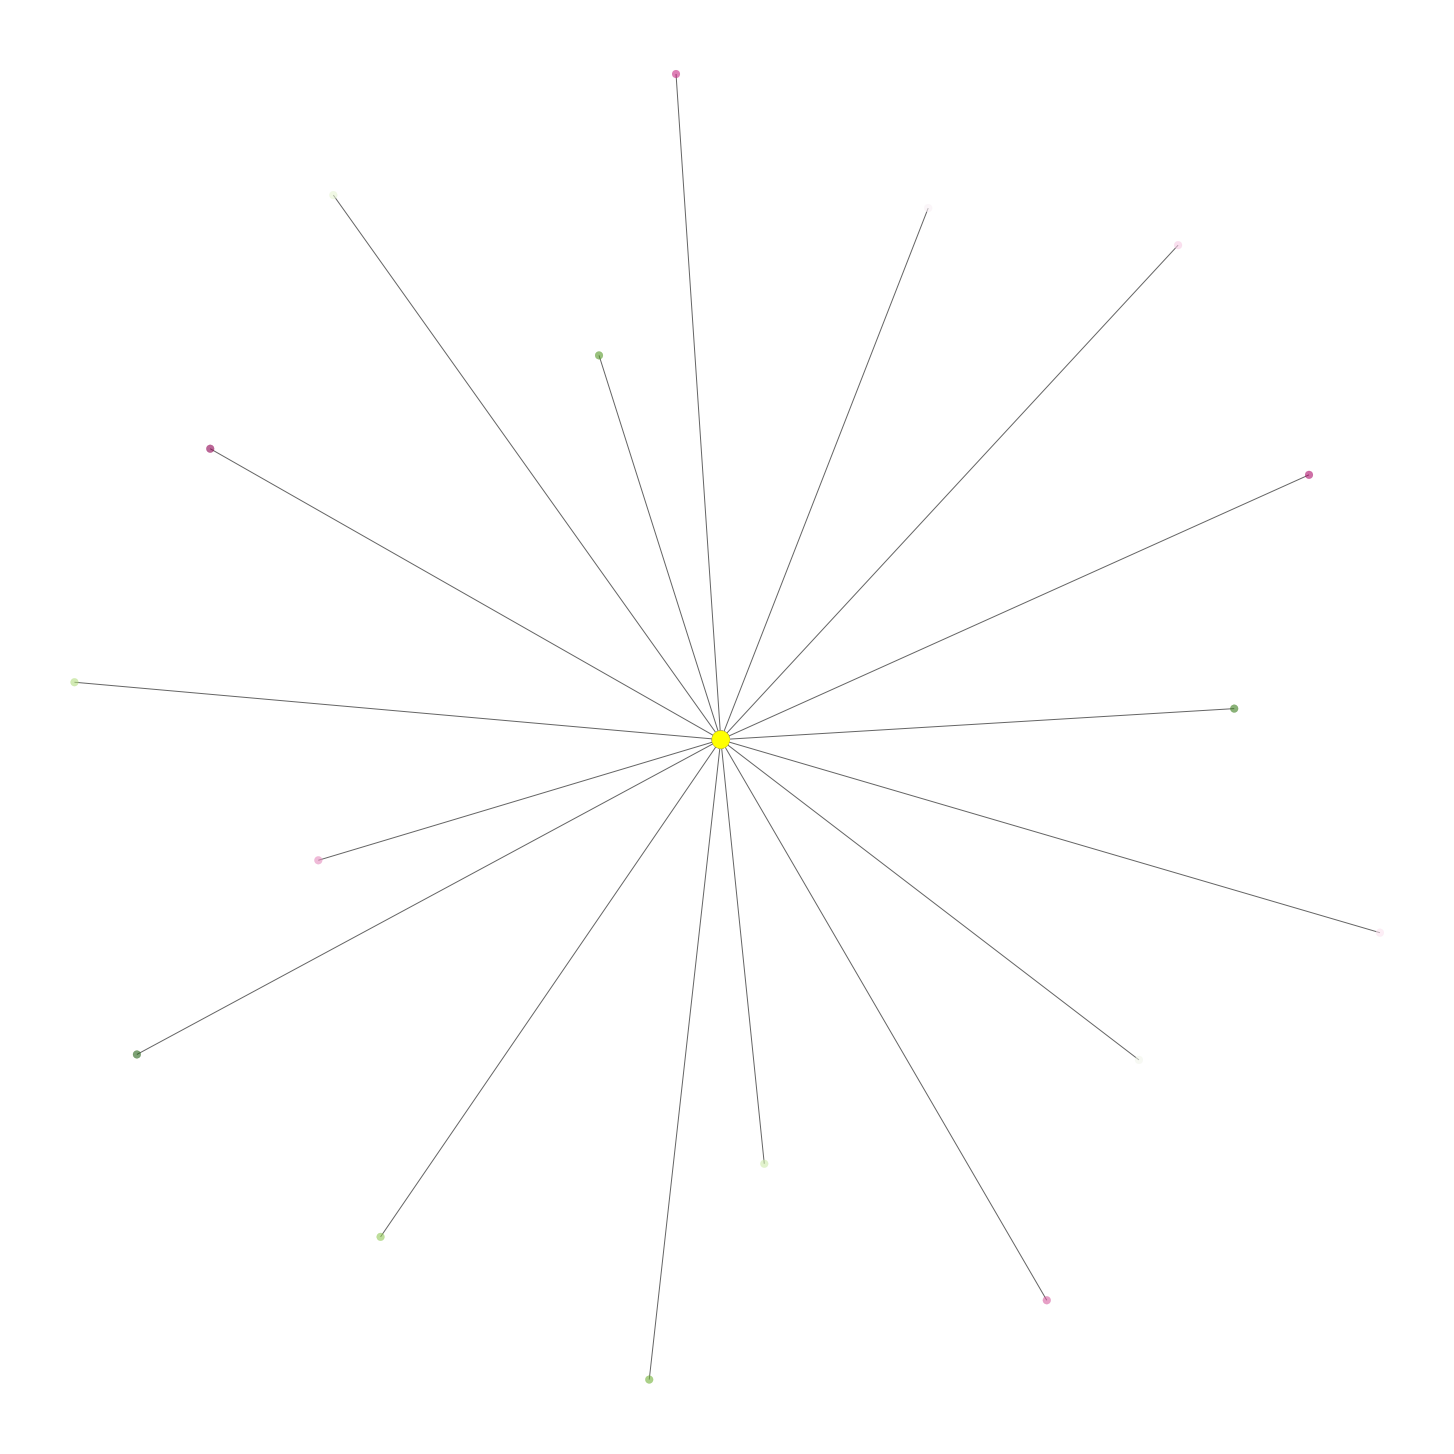

In [28]:
# Drawing of the subgraph
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'blue', 'yellow']
central_nodes = [degree_node, closeness_node, betweenness_node]

pos = nx.spring_layout(largest_subgraph, k=0.05)

plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(nb_of_subgraph_nodes), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.savefig('networkx_subgraph.png')
plt.show()

### c2) Drawing the graph

In [29]:
graph_centrality = nx.degree_centrality(graph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(graph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(graph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

degree_node = max_de[0]
closeness_node = max_clo[0]
betweenness_node = max_bet[0]
print(f"The node with id {degree_node} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"The node with id {closeness_node} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"The node with id {betweenness_node} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

The node with id 2398454779 has a degree centrality of 0.16 which is the maximum of the Graph
The node with id 2398454779 has a closeness centrality of 0.16 which is the maximum of the Graph
The node with id 2398454779 has a betweenness centrality of 0.03 which is the maximum of the Graph


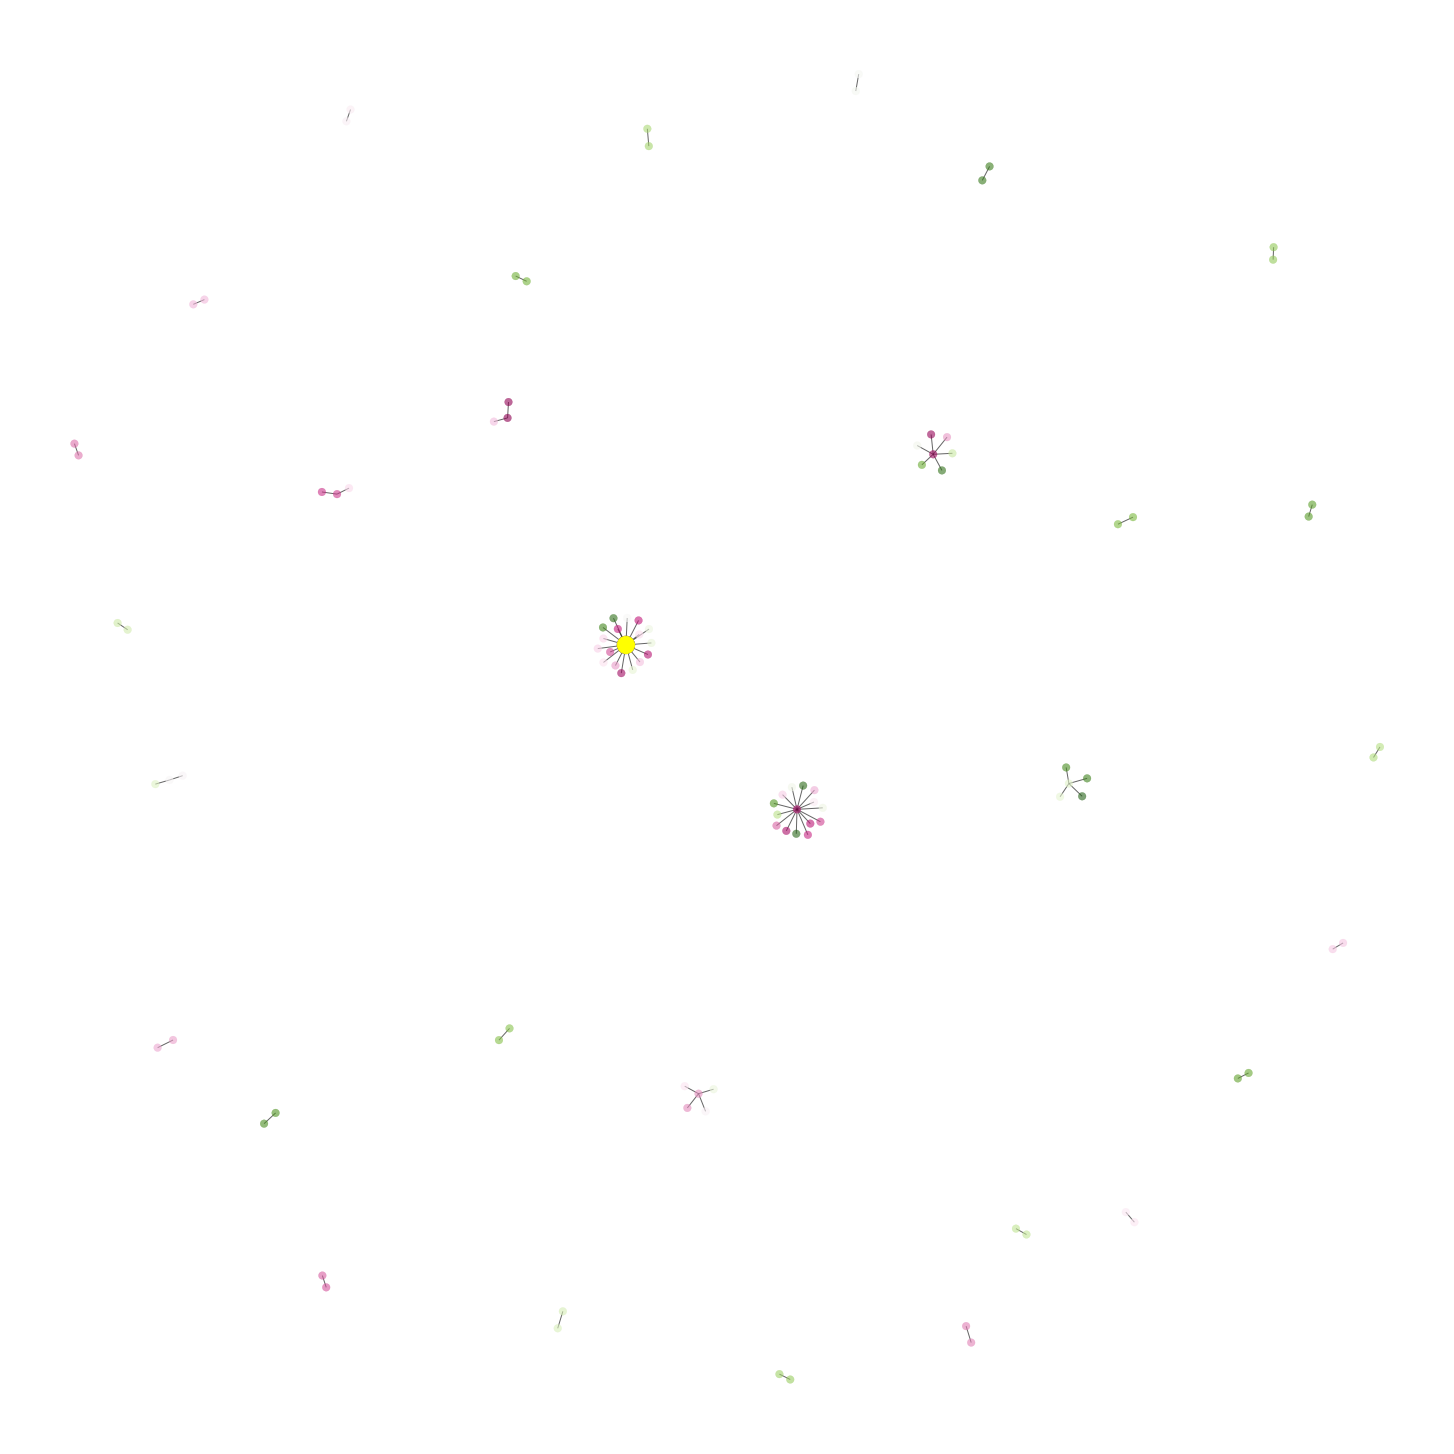

In [30]:
node_and_degree = graph.degree()
colors_central_nodes = ['orange', 'blue', 'yellow']
central_nodes = [degree_node, closeness_node, betweenness_node]

pos = nx.spring_layout(graph, k=0.05)


plt.figure(figsize = (20,20))
nx.draw(graph, pos=pos, node_color=range(nb_of_graph_nodes), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(graph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.savefig('networkx_graph.png')
plt.show()

### d) Touching the graph

In [31]:
# get Source and Targets
source_lst = []
target_lst = []
weight_lst = []
for e in graph.edges():
    source,target = e
    #print(source,target)
    source_lst.append(source)
    target_lst.append(target)
    weight_lst.append(0)

# DataFrame
data_source_target = {'Source':source_lst,
                      'Target':target_lst,
                      'Weight':weight_lst}   
df_graph = pd.DataFrame(data_source_target)
df_graph.astype({'Source': 'str'}).dtypes
df_graph.astype({'Target': 'str'}).dtypes
df_graph.astype({'Weight': 'str'}).dtypes
df_graph.to_csv('df_graph.csv', index=False)
df_graph.head()

,Source,Target,Weight
0,1281669801249775617,1210890516721631233,0
1,1281669801249775617,1268654112738103307,0
2,271439132,726365373965152257,0
3,726365373965152257,946377666,0
4,726365373965152257,1023945297838452737,0


In [32]:
graph_dynamic_data = pd.read_csv("df_graph.csv")

graph_dynamic = nx.Graph()

sources = graph_dynamic_data['Source']
targets = graph_dynamic_data['Target']
weights = graph_dynamic_data['Weight']
edge_data = zip(sources, targets, weights)
for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    graph_dynamic.add_node(src)
    graph_dynamic.add_node(dst)
    graph_dynamic.add_edge(src, dst, value=w)

# add neighbor data to node hover data
#for node in got_net.nodes:
#    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
#    node["value"] = len(neighbor_map[node["id"]])

# need to be improved because Network() should be defined first so I could give add_node() parameters
# like here https://pyvis.readthedocs.io/en/latest/tutorial.html#adding-list-of-nodes-with-properties
graph_dynamic_net = Network(height="450px", width="100%", bgcolor="#222222", font_color="white", notebook=True)
graph_dynamic_net.barnes_hut() # set the physics layout of the network
# populates the nodes and edges data structures
graph_dynamic_net.from_nx(graph_dynamic)
graph_dynamic_net.show("graph_dynamic.html")